In [1]:
# importing dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import seaborn as sns

# For model building
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Optimizations
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
# Load in the data
weather = pd.read_csv("~/Projects/NiceRide/Weather_data/01012010_12312017.csv") # Weather data

temp = []
for x in [2010 + x for x in range(8)] :
#   add dtype declaration to remove warning
    x = pd.read_csv("~/Projects/NiceRide/Nice_Ride_data/"+str(x)+"/NiceRide_trip_history_"+str(x)+".csv")
                   # dtype = {"Start station ID" : pd.int64, "End station ID" : pd.int64, "Account type": pd.Categorical}
    temp.append(x)
    nr = pd.concat(temp)

/home/grimoire/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Changing dates from objects into datetimes
weather['DATE'] = weather['DATE'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

nr['Start date'] = nr['Start date'].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y %H:%M'))
nr['End date'] = nr['End date'].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y %H:%M'))

In [4]:
# Changing TAVG-NAN values to the mean of the TMAX and TMIN
weather = weather.fillna(value={'TAVG': weather[weather.TAVG.isna()][['TMAX', 'TMIN']]
                                .agg("mean", axis="columns")})

In [5]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 10 columns):
STATION    2922 non-null object
NAME       2922 non-null object
DATE       2922 non-null datetime64[ns]
AWND       2922 non-null float64
PRCP       2922 non-null float64
SNOW       2922 non-null float64
SNWD       2922 non-null int64
TAVG       2922 non-null float64
TMAX       2922 non-null int64
TMIN       2922 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 228.4+ KB


In [6]:
nr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2694187 entries, 0 to 460715
Data columns (total 8 columns):
Start date                  datetime64[ns]
Start station               object
Start station ID            object
End date                    datetime64[ns]
End station                 object
End station ID              object
Account type                object
Total duration (seconds)    int64
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 185.0+ MB


In [7]:
# Resampling our NR data so it takes the start date and Total duration, returns a count of rides per day 'daily_totals'

daily_totals = nr[['Start date', 'Total duration (seconds)']].resample('D', on='Start date').count()
daily_totals = daily_totals.drop('Start date', axis=1)
daily_totals = daily_totals.reset_index()
daily_totals = daily_totals.rename(index=str, columns={"Total duration (seconds)": "Dcount",'Start date':'DATE'})

In [8]:
daily_totals.info()
daily_totals.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2709 entries, 0 to 2708
Data columns (total 2 columns):
DATE      2709 non-null datetime64[ns]
Dcount    2709 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 63.5+ KB


,DATE,Dcount
0,2010-06-07,1
1,2010-06-08,2
2,2010-06-09,7
3,2010-06-10,104
4,2010-06-11,287


In [9]:
weather.keys()
weather = weather.drop(['STATION', 'NAME', 'SNOW', 'SNWD'], axis=1)

In [10]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 6 columns):
DATE    2922 non-null datetime64[ns]
AWND    2922 non-null float64
PRCP    2922 non-null float64
TAVG    2922 non-null float64
TMAX    2922 non-null int64
TMIN    2922 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 137.0 KB


In [11]:
temp = weather.merge(daily_totals, how='outer',on='DATE')
temp.info()
temp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 7 columns):
DATE      2922 non-null datetime64[ns]
AWND      2922 non-null float64
PRCP      2922 non-null float64
TAVG      2922 non-null float64
TMAX      2922 non-null int64
TMIN      2922 non-null int64
Dcount    2709 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 182.6 KB


,DATE,AWND,PRCP,TAVG,TMAX,TMIN,Dcount
0,2010-01-01,8.95,0.0,-1.5,6,-9,NaN
1,2010-01-02,4.03,0.0,-7.0,1,-15,NaN
2,2010-01-03,2.91,0.0,-3.5,7,-14,NaN
3,2010-01-04,5.59,0.0,-1.5,7,-10,NaN
4,2010-01-05,3.13,0.0,0.5,10,-9,NaN


In [12]:
train_test_data = temp.fillna(value=0,axis=0) # Where we don't have a daily count (Dcount) fill this with zeros instead
train_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 7 columns):
DATE      2922 non-null datetime64[ns]
AWND      2922 non-null float64
PRCP      2922 non-null float64
TAVG      2922 non-null float64
TMAX      2922 non-null int64
TMIN      2922 non-null int64
Dcount    2922 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 182.6 KB


In [13]:
# Need to drop all days where there where no rides taken (Dcount = 0)
train_data = train_test_data[train_test_data['Dcount'] != 0].reset_index(drop=True)

In [14]:
# All the weather data where there is no ride data, Dcount = 0
gen_data = train_test_data[train_test_data['Dcount'] == 0].reset_index(drop=True)
gen_data.describe()

,AWND,PRCP,TAVG,TMAX,TMIN,Dcount
count,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1255.0
mean,9.165235,0.044861,27.729084,35.314741,19.905976,0.0
std,3.740975,0.141718,16.218649,17.169311,16.053859,0.0
min,0.890000,0.000000,-17.000000,-12.000000,-23.000000,0.0
25%,6.490000,0.000000,17.000000,24.000000,9.000000,0.0
50%,8.720000,0.000000,28.000000,34.000000,20.000000,0.0
75%,11.520000,0.010000,37.250000,45.000000,31.000000,0.0
max,24.610000,1.730000,83.500000,95.000000,73.000000,0.0


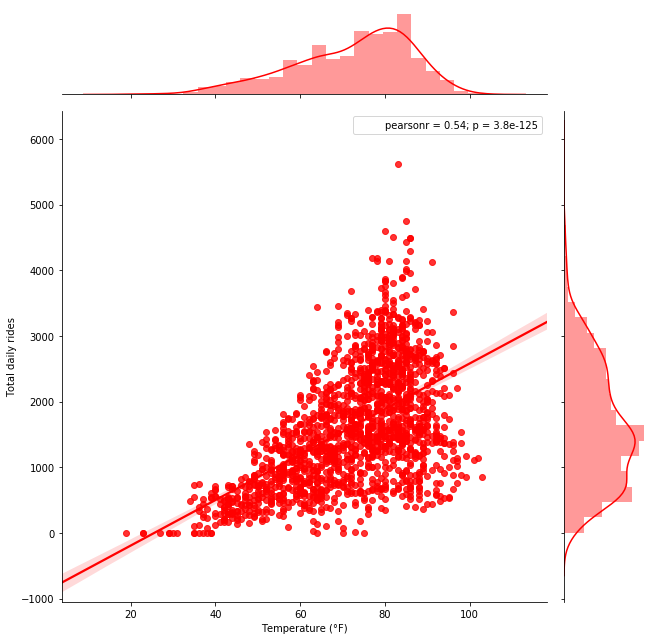

In [15]:
sns.jointplot('TMAX', 'Dcount', data=train_data, kind='reg', color='r', size=9)
plt.xlabel('Temperature (°F)')
plt.ylabel('Total daily rides')
plt.margins(.02)

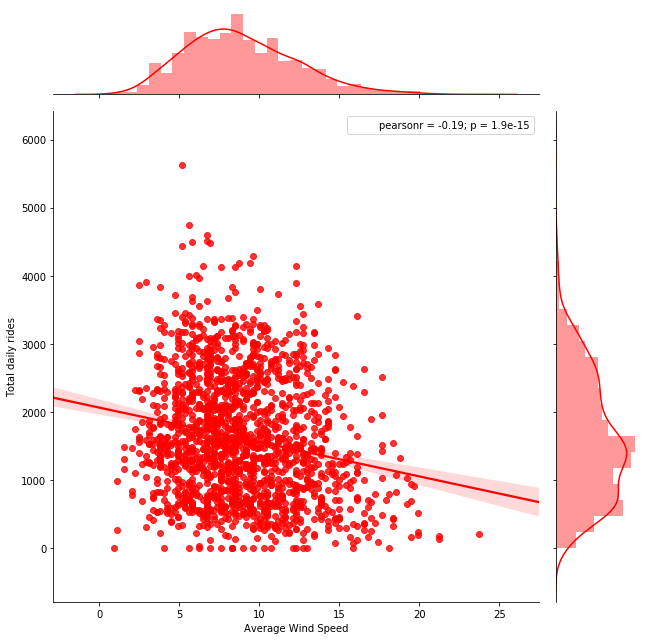

In [16]:
sns.jointplot('AWND', 'Dcount', data=train_data, kind='reg', color='r', size=9)
plt.xlabel('Average Wind Speed')
plt.ylabel('Total daily rides')
plt.margins(.02)

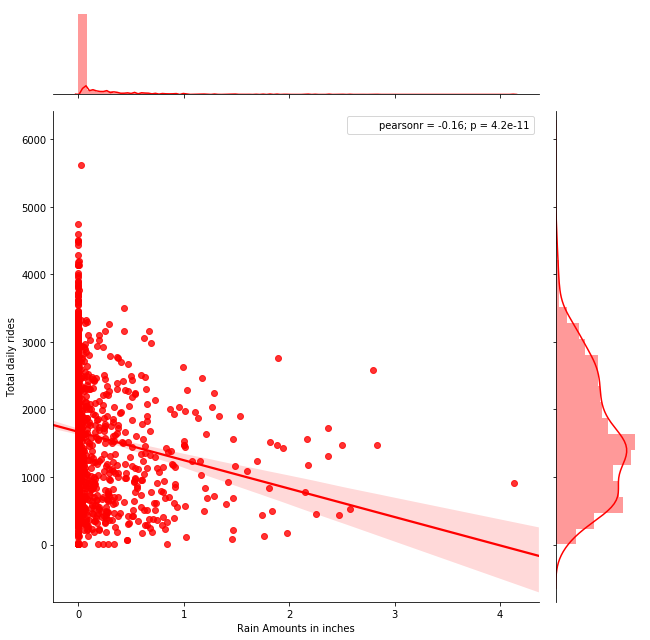

In [17]:
sns.jointplot('PRCP', 'Dcount', data=train_data, kind='reg', color='r', size=9)
plt.xlabel('Rain Amounts in inches')
plt.ylabel('Total daily rides')
plt.margins(.02)

In [18]:
X = train_data.drop(['DATE', 'Dcount'], axis=1)
# X = train_test_data.drop(['DATE', 'AWND', 'PRCP', 'TAVG', 'TMIN', 'Dcount'], axis=1) # For testing purposes
y = train_data.drop(['DATE', 'AWND', 'PRCP', 'TAVG','TMAX', 'TMIN'], axis=1)

In [19]:
X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Data columns (total 5 columns):
AWND    1667 non-null float64
PRCP    1667 non-null float64
TAVG    1667 non-null float64
TMAX    1667 non-null int64
TMIN    1667 non-null int64
dtypes: float64(3), int64(2)
memory usage: 65.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1667 entries, 0 to 1666
Data columns (total 1 columns):
Dcount    1667 non-null float64
dtypes: float64(1)
memory usage: 13.1 KB


In [20]:
print(X.describe())
print(y.describe())

              AWND         PRCP         TAVG         TMAX         TMIN
count  1667.000000  1667.000000  1667.000000  1667.000000  1667.000000
mean      8.857259     0.126023    63.063287    72.171566    53.988002
std       3.451232     0.344777    13.021535    13.991099    12.666982
min       0.890000     0.000000     8.000000    19.000000    -3.000000
25%       6.490000     0.000000    54.000000    63.000000    45.000000
50%       8.500000     0.000000    66.000000    75.000000    56.000000
75%      10.960000     0.050000    73.000000    83.000000    64.000000
max      23.710000     4.130000    91.000000   103.000000    81.000000
            Dcount
count  1667.000000
mean   1616.188962
std     903.294550
min       1.000000
25%     883.000000
50%    1501.000000
75%    2291.500000
max    5625.000000


In [21]:
X_lin = X.TMAX.values
print(X_lin.shape)
y_lin = y.Dcount.values
print(y_lin.shape)

(1667,)
(1667,)


In [22]:
# Setting up the variables

X_lin = X.TMAX.values
y_lin = y.Dcount.values

# Splitting the data
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, test_size=.3, random_state=42) # for Douglas Adams.

# Building the model
lin_reg = LinearRegression()

# Fitting the model
lin_reg.fit(Xlr, ylr)

# Predict the labels
y_pred = lin_reg.predict(Xlr)

print(lin_reg.score(X,y))

0.3184707143937485


In [23]:
# Split the data into a training and test set.

Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, test_size=.3, random_state=42) # for Douglas Adams.

log_reg = LogisticRegression()

# Fit the model on the trainng data.
log_reg.fit(Xlr, ylr)

# Predict the labels
y_pred = log_reg.predict(Xlr)
# Print the accuracy from the testing data.
print(accuracy_score(log_reg.predict(Xtestlr), ytestlr))

/home/grimoire/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.001996007984031936


**0.001996 - Back to the drawing board**

** Scaling the features **

In [24]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, test_size=.3, random_state=42)

clf = make_pipeline(StandardScaler(), LogisticRegression())

clf.fit(X,y)
y_pred = clf.predict(Xlr)

print(accuracy_score(clf.predict(Xtestlr), ytestlr))

/home/grimoire/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.005988023952095809


## Ignore below this

In [25]:
print(confusion_matrix(ylr, y_pred))
print(classification_report(ylr, y_pred))

[[7 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
             precision    recall  f1-score   support

        1.0       0.03      0.88      0.05         8
        2.0       0.00      0.00      0.00         2
        6.0       0.00      0.00      0.00         1
        7.0       0.00      0.00      0.00         1
       30.0       0.00      0.00      0.00         1
       69.0       0.00      0.00      0.00         1
       73.0       0.00      0.00      0.00         1
      104.0       0.00      0.00      0.00         1
      112.0       0.00      0.00      0.00         1
      119.0       0.00      0.00      0.00         1
      130.0       0.50      1.00      0.67         1
      138.0       0.00      0.00      0.00         1
      147.0       0.00      0.00      0.00         1
      165.0       0.00      0.00      0.00         1
      166.0       0.00      0.00      0.00         1
      175.0       0.00      0.0

/home/grimoire/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/grimoire/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [26]:
'''
# Compute predicted probabilities: y_pred_prob
y_pred_prob = log_reg.predict_proba(Xtestlr)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(ytestlr, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
'''

"\n# Compute predicted probabilities: y_pred_prob\ny_pred_prob = log_reg.predict_proba(Xtestlr)[:,1]\n\n# Generate ROC curve values: fpr, tpr, thresholds\nfpr, tpr, thresholds = roc_curve(ytestlr, y_pred_prob)\n\n# Plot ROC curve\nplt.plot([0, 1], [0, 1], 'k--')\nplt.plot(fpr, tpr)\nplt.xlabel('False Positive Rate')\nplt.ylabel('True Positive Rate')\nplt.title('ROC Curve')\nplt.show()\n"

In [27]:
# Precision-recall Curve
# Goes here

In [28]:
# GridSearchCV
print(log_reg.get_params)

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>


In [29]:
# Sinoidal model for fitting
# https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
# https://exnumerus.blogspot.com/2010/04/how-to-fit-sine-wave-example-in-python.html